In [1]:
%pip install datasets
%pip install python-dotenv


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
""" # It's not working!

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from dotenv import load_dotenv

TRAIN_SIZE = 100
VAL_SIZE = 10
BATCH_SIZE = 8

torch.manual_seed(1)
load_dotenv()

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor()
])
transform_validation = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor(),
])

def check_range(tensor):
    return (tensor.min() >= 0) and (tensor.max() <= 1)

def prepare_dataset(train_size=10,test_size=10,batch_size=8):
    login_token = os.getenv('HUGGING_FACE_TOKEN')
    dataset_train = load_dataset("imagenet-1k",split='train',use_auth_token=login_token,streaming=True)
    dataset_validation = load_dataset("imagenet-1k",split='test',use_auth_token=login_token,streaming=True)

    # map resize transformation before take
    transformed_train = dataset_train.map(lambda x: {'image': transform_train(x['image']), 'grayscale_image': transform_validation(x['image']),'label': torch.tensor(x['label'])})
    transformed_test = dataset_validation.map(lambda x: {'image': transform_validation(x['image']),'label': torch.tensor(x['label'])})

    # shuffle train dataset
    transformed_train = transformed_train.shuffle()

    print("Dataset loaded successfully")
    return transformed_train.take(train_size),transformed_test.take(test_size)

class RecreationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        return {'image': image}

def prepare_dataloader(train_data,test_data,batch_size=4):

    # prepare data loader
    list_train_data = list(train_data)
    # filter out 1 channel images
    train_data = list(filter(lambda x: x['image'].shape[0] == 3, list_train_data))

    colorization_dataset_train = RecreationDataset(train_data)
    colorization_dataloader_train = DataLoader(colorization_dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

    colorization_dataset_validation = RecreationDataset(list(test_data), test=True)
    colorization_dataloader_validation = DataLoader(colorization_dataset_validation, batch_size=batch_size, shuffle=False, num_workers=4)

    print("Data loader prepared successfully")
    return colorization_dataloader_train, colorization_dataloader_validation

train_data, validation_data = prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE)
train_loader, validation_loader = prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)
 """

' # It\'s not working!\n\nfrom datasets import load_dataset\nfrom torch.utils.data import Dataset, DataLoader\nfrom PIL import Image\nfrom dotenv import load_dotenv\n\nTRAIN_SIZE = 100\nVAL_SIZE = 10\nBATCH_SIZE = 8\n\ntorch.manual_seed(1)\nload_dotenv()\n\ntransform_train = torchvision.transforms.Compose([\n    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),\n    torchvision.transforms.ToTensor()\n])\ntransform_validation = torchvision.transforms.Compose([\n    torchvision.transforms.Resize((256, 256), interpolation=Image.BILINEAR),\n    torchvision.transforms.ToTensor(),\n])\n\ndef check_range(tensor):\n    return (tensor.min() >= 0) and (tensor.max() <= 1)\n\ndef prepare_dataset(train_size=10,test_size=10,batch_size=8):\n    login_token = os.getenv(\'HUGGING_FACE_TOKEN\')\n    dataset_train = load_dataset("imagenet-1k",split=\'train\',use_auth_token=login_token,streaming=True)\n    dataset_validation = load_dataset("imagenet-1k",split=\'test\',use_auth_token

In [3]:
import torch
import torchvision
import torch.nn as nn
from IPython.display import Markdown, display
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import sys
sys.path.append("src/")

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"Device: {device}")

# print(torch.cuda.get_device_name(0))
# sns.set()

Device: cuda


In [4]:
#import os
#from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Create a folder in the root directory
#!mkdir -p "/content/drive/My Drive/CV-19-03-2024"


#gdrive_path = '/content/drive/My Drive/CV-19-03-2024'

In [5]:
TRAIN_SIZE = 1200
VAL_SIZE = 300
BATCH_SIZE = 16
import dataset
# import imp, dataset
# imp.reload(dataset)
#from dataset import prepare_dataset, prepare_dataloader

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE)
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)

Dataset loaded successfully
Data loader prepared successfully


In [6]:
class UNet(nn.Module):
    def __init__(self, in_C = 3, out_C=3):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)


    def forward(self,x):
        x=x.to(device)
        # Encoder
        conv1 = self.conv1(x)
        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)
        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)
        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)
        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)

        # Decoder
        concatenation_5to6 = torch.cat((conv4, self.conv_transpose_5to6(conv5)),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        concatenation_6to7 = torch.cat((conv3, self.conv_transpose_6to7(conv6)),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)

        concatenation_7to8 = torch.cat((conv2, self.conv_transpose_7to8(conv7)),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        concatenation_8_to9 = torch.cat((conv1, self.conv_transpose8to9(conv8)),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)

        output = self.conv10(conv9)
        return output

    def train_model(self, train_loader, val_loader, epochs=10, lr=0.001, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam, verbose=True, save_path = "./model_storage/", save_name_prefix='/'):

        '''
        save_path = folder for saving results
        save_name_prefix = prefix for saved files to mark experiments (start with '/')


        '''


        loss_df = pd.DataFrame(['training_loss', 'validation_loss'])
        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr)

        #for saving progress
        best_val_loss = 99999
        val_loss_list = []
        training_loss_list = []

        for epoch in tqdm(range(epochs)):
            training_loss = 0
            for i, batch_data in enumerate(train_loader):
                image = batch_data['image']
                image = image.to(device)
                optimizer.zero_grad()
                reproduced_image = self(image)
                reproduced_image = reproduced_image.to(device)
                loss = loss_fn(reproduced_image, image)
                training_loss += loss.item()
                loss.backward()
                optimizer.step()

            #average training loss
            training_loss /= len(train_loader)
            training_loss_list.append(training_loss)


            if (epoch)%5 == 0 or (epoch + 1) == epochs:
                val_loss = 0.0  # Track validation loss
                with torch.no_grad():  # Disable gradient calculation for validation
                    for val_data in val_loader:
                        val_image = val_data['image']
                        val_image = val_image.to(device)

                        val_reproduced_image = self(val_image)
                        val_reproduced_image = val_reproduced_image.to(device)

                        val_loss += loss_fn(val_reproduced_image, val_image).item()

                val_loss /= len(val_loader)  # Calculate average validation loss
                val_loss_list.append(val_loss)

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {training_loss}")
                  print(f"Epoch {epoch}: validation loss = {val_loss}")


                if val_loss < best_val_loss:  # Update best validation loss and save checkpoint if best model
                  state_diction = self.state_dict()
                  best_val_loss = val_loss
                  for key in state_diction.keys():
                      state_diction[key] = state_diction[key].to(torch.device('cpu'))
                  torch.save(state_diction, (save_path+save_name_prefix+f"UNet_best_model.pth.tar"))

                #construct df with losses
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  'training_loss':training_loss_list, 'val_loss': val_loss_list})
                loss_df.to_csv(save_path+save_name_prefix+"UNet_loss.csv", index=False)
                # plot losses
                plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                plt.plot(loss_df['epoch'], loss_df['val_loss'].interpolate(method='linear'), label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()

                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'UNet_loss_plot.png')
                plt.clf()
            else:
              val_loss_list.append(np.nan)


net=UNet()

In [8]:
net.train_model(train_loader=train_loader, val_loader=validation_loader, epochs=200, lr=0.0001, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam, verbose=True, save_path= 'experiment_results/size_1200_200ep_lab', save_name_prefix='/1000_training_')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, training_loss = 0.17020080844561258
Epoch 0: validation loss = 0.16212150768229835


  2%|▎         | 5/200 [01:31<59:03, 18.17s/it]  

Epoch 5, training_loss = 0.040911234294374786
Epoch 5: validation loss = 0.031742947666268596


  5%|▌         | 10/200 [03:04<57:41, 18.22s/it] 

Epoch 10, training_loss = 0.0014841279309863846
Epoch 10: validation loss = 0.0013799992524773667


  8%|▊         | 15/200 [04:37<56:24, 18.29s/it]

Epoch 15, training_loss = 0.0010020216597088924
Epoch 15: validation loss = 0.0008936352617303399


 10%|█         | 20/200 [06:09<54:56, 18.31s/it]

Epoch 20, training_loss = 0.0007636684687652935
Epoch 20: validation loss = 0.0007956723137268503


 12%|█▎        | 25/200 [07:43<53:51, 18.47s/it]

Epoch 25, training_loss = 0.0006658549890077363
Epoch 25: validation loss = 0.0007022189981255092


 16%|█▌        | 31/200 [09:37<53:33, 19.01s/it]

Epoch 30, training_loss = 0.0008865515212528408
Epoch 30: validation loss = 0.0007069572809421899


 18%|█▊        | 35/200 [10:50<50:57, 18.53s/it]

Epoch 35, training_loss = 0.0007719055908576896
Epoch 35: validation loss = 0.000655918397426017


 20%|██        | 40/200 [12:24<49:21, 18.51s/it]

Epoch 40, training_loss = 0.0006085682346019894
Epoch 40: validation loss = 0.0006475093587620282


 23%|██▎       | 46/200 [14:18<48:50, 19.03s/it]

Epoch 45, training_loss = 0.0006474478395345311
Epoch 45: validation loss = 0.0006621907063833389


 25%|██▌       | 50/200 [15:32<46:23, 18.55s/it]

Epoch 50, training_loss = 0.0006201565690571443
Epoch 50: validation loss = 0.0006085785295765259


 28%|██▊       | 55/200 [17:05<44:43, 18.50s/it]

Epoch 55, training_loss = 0.0005801383543681974
Epoch 55: validation loss = 0.0005707130828676256


 30%|███       | 61/200 [18:59<43:59, 18.99s/it]

Epoch 60, training_loss = 0.0005706167937993693
Epoch 60: validation loss = 0.0006203264240052943


 33%|███▎      | 66/200 [20:32<42:10, 18.88s/it]

Epoch 65, training_loss = 0.0007270918966969475
Epoch 65: validation loss = 0.0005732175103682829


 36%|███▌      | 71/200 [22:05<40:32, 18.86s/it]

Epoch 70, training_loss = 0.0006115148412451769
Epoch 70: validation loss = 0.0006125374332585029


 38%|███▊      | 75/200 [23:18<38:09, 18.32s/it]

Epoch 75, training_loss = 0.0005526929182815366
Epoch 75: validation loss = 0.0005398908458454045


 40%|████      | 81/200 [25:10<37:22, 18.85s/it]

Epoch 80, training_loss = 0.0006508507120694655
Epoch 80: validation loss = 0.0005708902654556656


 42%|████▎     | 85/200 [26:23<35:12, 18.37s/it]

Epoch 85, training_loss = 0.000419689441138568
Epoch 85: validation loss = 0.0005102466951173387


 46%|████▌     | 91/200 [28:16<34:21, 18.91s/it]

Epoch 90, training_loss = 0.0005119619677619387
Epoch 90: validation loss = 0.0005383291641728169


 48%|████▊     | 96/200 [29:50<32:59, 19.03s/it]

Epoch 95, training_loss = 0.0006215764197986573
Epoch 95: validation loss = 0.0005562345506500845


 50%|█████     | 101/200 [31:24<31:31, 19.10s/it]

Epoch 100, training_loss = 0.000561538222245872
Epoch 100: validation loss = 0.0005123906326173854


 53%|█████▎    | 106/200 [32:58<29:58, 19.13s/it]

Epoch 105, training_loss = 0.0004785853071371093
Epoch 105: validation loss = 0.000538032799867276


 53%|█████▎    | 106/200 [33:09<29:24, 18.77s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

torch.Size([3, 128, 128])


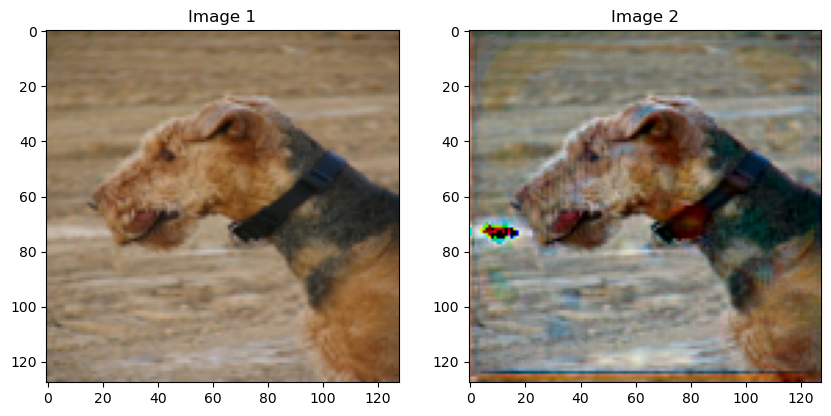

In [9]:
import matplotlib.pyplot as plt

def plot_both(image1,image2):
    plt.figure(figsize=(10, 5))

    # Plot first image
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot second image
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    plt.show()


def compose_output(original_image, recreated_image):
    print(original_image.shape)
    print(recreated_image.shape)
    l = original_image[0,:,:]
    print("L shape",l.shape)
    return torch.cat((l.unsqueeze(0),recreated_image),0)

'''
NOTE: when using lab color space we have certain artefacts that do not appear when we only use RGB images

may be from normalization in the lab space or the transformation itself

TODO
'''
def visualize(image,model,lab=False):
    output = model(image.unsqueeze(0).to(device))
    output = output.detach().cpu().squeeze(0)
    print(output.shape)

    if lab:
        lab2rgb = dataset.LABtoRGB()
        image = lab2rgb(image)
        output = lab2rgb(output)
    # output = compose_output(image,output[0])

    plot_both(image.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())

visualize(list(train_data)[17]['image'],net,lab=True)

torch.Size([3, 128, 128])


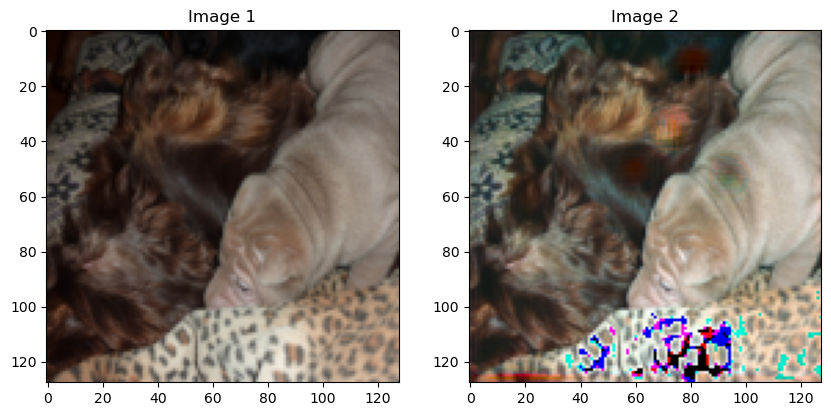

In [10]:

visualize(list(train_data)[15]['image'],net,lab=True)

torch.Size([3, 128, 128])


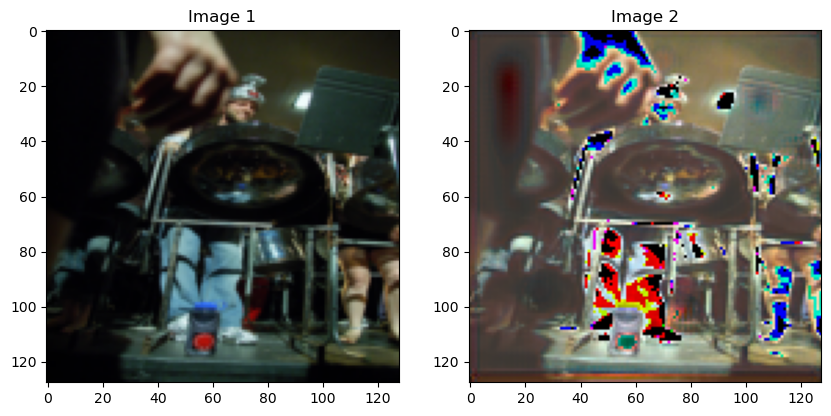

In [11]:

visualize(list(train_data)[11]['image'],net,lab=True)

In [12]:

def plot_grid(images_column1, images_column2):
    '''
    Plots a 2x8 grid of rgb images, where each row corresponds to a pair of images from the two input lists.
    '''
    num_images_column1 = len(images_column1)
    num_images_column2 = len(images_column2)
    num_rows = max(num_images_column1, num_images_column2)
    
    plt.figure(figsize=(12, 8))  # Adjust figsize as needed

    for i in range(num_rows):
        # Plot images from the first column
        if i < num_images_column1:
            plt.subplot(num_rows, 2, 2*i + 1)
            plt.imshow(images_column1[i].permute(1,2,0).numpy())
            # plt.title(f'Image {i + 1} (Column 1)')
            plt.axis('off')  # Turn off axis for better visualization
        
        # Plot images from the second column
        if i < num_images_column2:
            plt.subplot(num_rows, 2, 2*i + 2)
            plt.imshow(images_column2[i].permute(1,2,0).numpy())
            # plt.title(f'Image {i + 1} (Column 2)')
            plt.axis('off')  # Turn off axis for better visualization

    plt.tight_layout(pad=0.1)  # Adjust spacing between subplots
    plt.show()

def get_visualization_images(indexes):
    data = list(train_data)
    tbr = []
    for idx in indexes:
        tbr.append(data[idx]['image'])

    return tbr

def get_batch_outputs(images):
    ## batch the images
    images = torch.stack(images)
    output = net(images.to(device))
    return [output[i].detach().cpu() for i in range(output.shape[0])]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


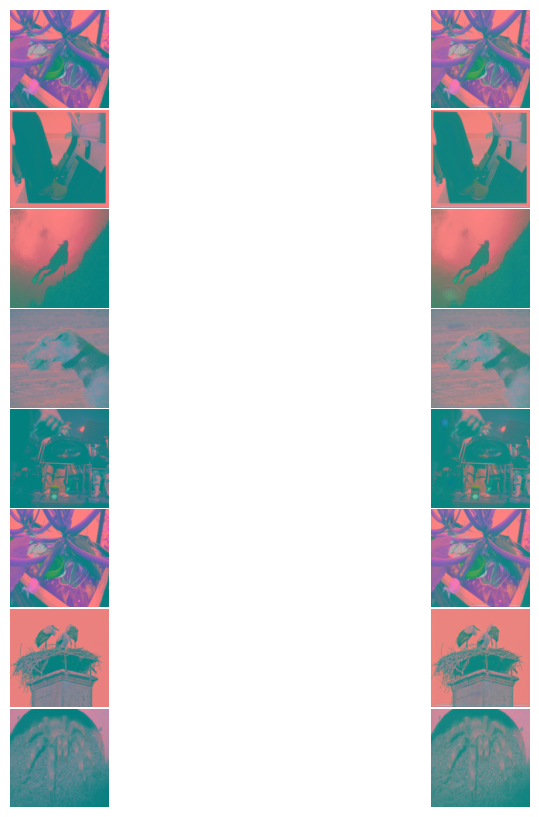

In [13]:
## must have length 8!
images_to_visualize_indexes = [3,12,5,17,11,3,28,29]

visualization_images = get_visualization_images(images_to_visualize_indexes)
outputs = get_batch_outputs(visualization_images)
plot_grid(visualization_images, outputs)